In [2]:
import numpy as np
import h5py
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import gridspec
from matplotlib.colors import colorConverter
plt.rc('text', usetex=True)

import seaborn as sns

import glob
import os
import pickle
import sys

from astropy.table import Table


In [23]:
from colossus.halo import mass_adv
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')

In [32]:
nbin=150
def get_median_profile(isos, pixel_scale, quantity = 'intens', rmin=0.05, rmax=4.7, nbin=nbin):
    """Get the median profiles."""
    sma_common = np.linspace(rmin, rmax, nbin)
    
    if quantity == 'intens':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25, 
                                               np.log10(gal[quantity] / (pixel_scale ** 2)),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(sma_common) 
                               for gal in isos]), axis=0)
    elif quantity == 'growth_ori':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25, 
                                               np.log10(gal[quantity]),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(sma_common) 
                               for gal in isos]), axis=0)
    

    return sma_common, mu

def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)#, encoding='latin')
    pkl.close()  
    return array

### files

In [33]:
#maps
Illustris_file_quick = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/galaxies_stellarmaps_orig_11.2.hdf5'
TNG_file_quick = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_stellarmaps_tng75_11.2.hdf5'

#isos
illustris_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_quick.pkl'
illustris_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_isos_quick.pkl'

tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_quick.pkl'
tng_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_quick.pkl'


In [34]:
illustris_masses = open_pkl(illustris_masses_file)
tng_masses = open_pkl(tng_masses_file)
illustris_isos = open_pkl(illustris_isos_file)
tng_isos = open_pkl(tng_isos_file)


In [6]:
#mass bins
#mass_bins = [13.0, 13.15, 13.4, 14.25]
mass_bins = np.linspace(13.0,14.25,4)

### Illustris 

In [71]:
sim_file = Illustris_file_quick

f = h5py.File(sim_file, 'r')
cat_sh_mstar = np.array(f['catsh_SubhaloMassType'][:, 4])
illustris_m_200c = np.log10(np.array(f['catgrp_Group_M_Crit200']))

z_illustris = f['config'].attrs['snap_z']

#convert to Mvir
illustris_m_vir, illustris_r_vir, illustris_c_vir = mass_adv.changeMassDefinitionCModel(10**illustris_m_200c,
                                                                                    z_illustris, '200c', 'vir',
                                                                              profile='nfw', c_model='diemer19')
illustris_m_vir = np.log10(illustris_m_vir)

# cen_insitu = np.array(f['map_star_rho_insitu_xy'])
# cen_exsitu = np.array(f['map_star_rho_exsitu_xy'])
# map_stars_cen = cen_exsitu + cen_insitu

# fuzz_insitu = np.array(f['map_star_rho_fuzz_insitu_xy'])
# fuzz_exsitu = np.array(f['map_star_rho_fuzz_exsitu_xy'])
# map_stars_fuzz = fuzz_exsitu + fuzz_insitu

# sats_insitu = np.array(f['map_star_rho_oshs_insitu_xy'])
# sats_exsitu = np.array(f['map_star_rho_oshs_exsitu_xy'])
# map_stars_sats = sats_exsitu + sats_insitu

map_size = f['config'].attrs['map_range_min']
n_pixels = f['config'].attrs['map_npixel']
pixel_scale=2 * (map_size/n_pixels)
f.close()

In [8]:
pixel_scale

5.333333333333333

### TNG 

In [67]:
sim_file = TNG_file_quick

f = h5py.File(sim_file, 'r')
cat_sh_mstar = np.array(f['catsh_SubhaloMassType'][:, 4])
tng_m_200c = np.log10(np.array(f['catgrp_Group_M_Crit200']))

z_tng = f['config'].attrs['snap_z']

#convert to Mvir
tng_m_vir, tng_r_vir, tng_c_vir = mass_adv.changeMassDefinitionCModel(10**tng_m_200c, z_tng, '200c', 'vir',
                                                                      profile='nfw', c_model='diemer19')
tng_m_vir = np.log10(tng_m_vir)

# cen_insitu = np.array(f['map_star_rho_insitu_xy'])
# cen_exsitu = np.array(f['map_star_rho_exsitu_xy'])
# map_stars_cen = cen_exsitu + cen_insitu

# fuzz_insitu = np.array(f['map_star_rho_fuzz_insitu_xy'])
# fuzz_exsitu = np.array(f['map_star_rho_fuzz_exsitu_xy'])
# map_stars_fuzz = fuzz_exsitu + fuzz_insitu

# sats_insitu = np.array(f['map_star_rho_oshs_insitu_xy'])
# sats_exsitu = np.array(f['map_star_rho_oshs_exsitu_xy'])
# map_stars_sats = sats_exsitu + sats_insitu

map_size = f['config'].attrs['map_range_min']
n_pixels = f['config'].attrs['map_npixel']
pixel_scale=2 * (map_size/n_pixels)

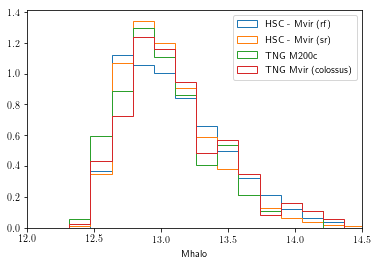

In [68]:
plt.hist(hsc_m_vir_rf, bins=np.linspace(12,15,20), density=True, histtype='step', label='HSC - Mvir (rf)')
plt.hist(hsc_m_vir_sr, bins=np.linspace(12,15,20), density=True, histtype='step', label='HSC - Mvir (sr)')
plt.hist(tng_m_200c, bins=np.linspace(12,15,20), density=True, histtype='step', label='TNG M200c')
plt.hist(tng_m_vir, bins=np.linspace(12,15,20), density=True, histtype='step', label='TNG Mvir (colossus)')

plt.xlim([12,14.5])
plt.xlabel('Mhalo')

plt.legend()
plt.show()

### histogram halo masses

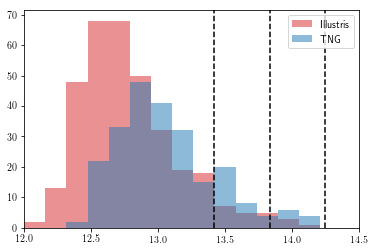

In [10]:
plt.hist(illustris_m_dm, bins=np.linspace(12,15,20), alpha=0.5, color=u'#d62728', label='Illustris')
plt.hist(tng_m_dm, bins=np.linspace(12,15,20), alpha=0.5, color=u'#1f77b4', label='TNG')

plt.xlim([12,14.5])

plt.axvline(mass_bins[1], linestyle='--', color='k')
plt.axvline(mass_bins[2], linestyle='--', color='k')
plt.axvline(mass_bins[3], linestyle='--', color='k')

plt.legend()
plt.show()

### HSC

In [10]:
hsc_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/s16a_mass_good_mhalo_frac4_180503.fits'
hsc_table = Table.read(hsc_file)

In [11]:
hsc_table

object_id,ra,dec,clean_photometry,z_spec,z_best,z_phot,z_type,gcmodel_mag,gcmodel_mag_err,rcmodel_mag,rcmodel_mag_err,icmodel_mag,icmodel_mag_err,zcmodel_mag,zcmodel_mag_err,ycmodel_mag,ycmodel_mag_err,MSTAR,lum_max,lum_150,lum_120,lum_100,lum_75,lum_50,lum_25,lum_10,lum_5,lum_15,lum_30,lum_40,lum_60,logm_5,logm_10,logm_15,logm_25,logm_30,logm_40,logm_50,logm_60,logm_75,logm_100,logm_120,logm_150,logm_max,photoz_err68_min,photoz_err68_max,vdisp_sdss,vdisp_err_sdss,gama_id,fluxscale_gama,logms_gama,logms_err_gama,id_cluster_redm,p_mem_redm,z_lambda_redm,z_lambda_err_redm,lambda_redm,lambda_err_redm,p_cen_1_redm,id_camira,z_camira,n_cor_camira,logms_camira,id_mem_camira,w_mem_camira,SFR,AV,TAU,AGE,ZMETAL,r20_max,r50_max,r80_max,r90_max,r20_120,r50_120,r80_120,r90_120,r20_100,r50_100,r80_100,r90_100,c82_max,c82_120,c82_100,sbp [380],cog [380],logmh_peak_tree,logmh_vir_tree,rvir_tree,a50_tree,alm_tree,logmh_vir_forest,logmh_vir_scale,logmh_vir_symbol
int64,float64,float64,bool,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
36411452835250136,30.613758134288393,-6.251703103753976,True,0.2455199956893921,0.2455199956893921,nan,3,19.644949,0.0013391519,18.302479,0.0006901949,17.800547,0.0005568507,17.474731,0.00065442745,17.2878,0.00095760194,11.335116386413574,10.892291069030762,10.892291069030762,10.892291069030762,10.89211886415116,10.888172711533091,10.883019922869575,10.847723697315887,10.718396998837596,10.522770730150585,10.79146800227692,10.860436887167129,10.875530486443784,10.88578214319483,10.96823606427534,11.163862332962351,11.236933336401675,11.293189031440642,11.305902221291884,11.32099582056854,11.32848525699433,11.331247477319584,11.333638045657846,11.337584198275914,11.337756403155517,11.337756403155517,11.337756403155517,0.18615343,0.28853565,224.10475158691406,15.169625282287598,-9999,nan,nan,nan,-9999,nan,nan,nan,nan,nan,nan,-9999,nan,nan,nan,-9999,nan,-3.420933723449707,0.032395489513874054,0.0739976018667221,10.507848739624023,0.012091274373233318,2.5228153081232376,6.121308790887207,15.406181899298474,15.406181899298474,2.5228153081232376,6.121308790887207,15.406181899298474,15.406181899298474,2.5221068939330045,6.117951796137979,15.388062514546986,15.388062514546986,6.106741880664811,6.106741880664811,6.101272928424795,9.509244939687928 .. nan,-inf .. 11.329365584772521,12.719660148595894,12.719660148595894,345.87899799999997,0.35033333333333333,0.1307,12.940536330410902,12.903636540775414,12.817290160901607
36411452835250266,30.614361022138144,-6.2411354982269795,True,nan,0.48193803429603577,0.48193803429603577,8,21.116365,0.004830737,19.800766,0.0025724475,19.143824,0.0019552037,18.678288,0.0021620528,18.523756,0.0037061234,11.408201217651367,10.871868133544922,10.871868133544922,10.871868133544922,10.871868133544922,10.869088738788593,10.859815386180802,10.811742876712584,10.573990628203278,10.216764314006461,10.7127170462535,10.826288021238549,10.847754387326892,10.864109102948557,10.589507744609287,10.946734058806104,11.085460476856326,11.18448630731541,11.199031451841375,11.220497817929719,11.232558816783628,11.236852533551383,11.241832169391419,11.244611564147748,11.244611564147748,11.244611564147748,11.244611564147748,0.40821913,0.5480428,nan,nan,-9999,nan,nan,nan,-9999,nan,nan,nan,nan,nan,nan,-9999,nan,nan,nan,-9999,nan,0.5862884521484

In [25]:
hsc_m_vir_sr = hsc_table['logmh_vir_symbol']
hsc_m_vir_rf = hsc_table['logmh_vir_forest']

hsc_m100 = hsc_table['logm_100']
hsc_m30 = hsc_table['logm_30']
hsc_m10 = hsc_table['logm_10']

In [14]:
hsc_table.keys()

['object_id',
 'ra',
 'dec',
 'clean_photometry',
 'z_spec',
 'z_best',
 'z_phot',
 'z_type',
 'gcmodel_mag',
 'gcmodel_mag_err',
 'rcmodel_mag',
 'rcmodel_mag_err',
 'icmodel_mag',
 'icmodel_mag_err',
 'zcmodel_mag',
 'zcmodel_mag_err',
 'ycmodel_mag',
 'ycmodel_mag_err',
 'MSTAR',
 'lum_max',
 'lum_150',
 'lum_120',
 'lum_100',
 'lum_75',
 'lum_50',
 'lum_25',
 'lum_10',
 'lum_5',
 'lum_15',
 'lum_30',
 'lum_40',
 'lum_60',
 'logm_5',
 'logm_10',
 'logm_15',
 'logm_25',
 'logm_30',
 'logm_40',
 'logm_50',
 'logm_60',
 'logm_75',
 'logm_100',
 'logm_120',
 'logm_150',
 'logm_max',
 'photoz_err68_min',
 'photoz_err68_max',
 'vdisp_sdss',
 'vdisp_err_sdss',
 'gama_id',
 'fluxscale_gama',
 'logms_gama',
 'logms_err_gama',
 'id_cluster_redm',
 'p_mem_redm',
 'z_lambda_redm',
 'z_lambda_err_redm',
 'lambda_redm',
 'lambda_err_redm',
 'p_cen_1_redm',
 'id_camira',
 'z_camira',
 'n_cor_camira',
 'logms_camira',
 'id_mem_camira',
 'w_mem_camira',
 'SFR',
 'AV',
 'TAU',
 'AGE',
 'ZMETAL',
 'r2

# plot M100, Mhalo

In [72]:
illustris_m100 = illustris_masses['m_1d_100']
tng_m100 = tng_masses['m_1d_100']

In [73]:
def get_median(bins, x, y):
    
    x_y =np.vstack([x,y])
    
    bins_y=[]
    bins_x=[]
    
    for i in range(len(bins)-1):
        l=bins[i]
        u=bins[i+1]
        
        mask = [(x_y[0]>l) & (x_y[0]<u)]

        y_in_range = x_y[1][mask]
        x_in_range = x_y[0][mask]
        
        print(len(y_in_range))
        
        bins_y.append(np.median(y_in_range))
        bins_x.append(np.median(x_in_range))
        
    return bins_x, bins_y
               

In [74]:
n_bins=3
lower_bin = 13
upper_bin = 14.25
median_bins = np.linspace(lower_bin,upper_bin,n_bins+1)

bins_x_illustris_m100, bins_y_illustris_m100 = get_median(median_bins, illustris_m_vir, illustris_m100)
bins_x_tng_m100, bins_y_tng_m100 = get_median(median_bins, tng_m_vir, tng_m100)
bins_x_hsc_m100, bins_y_hsc_m100 = get_median(median_bins, hsc_m_vir_sr, hsc_m100)

63
21
6
82
35
13
9146
2807
638


/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


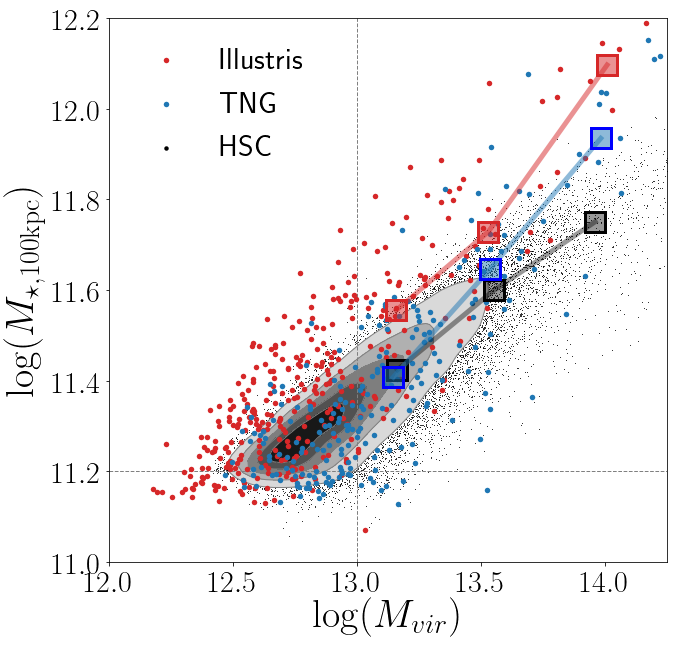

In [81]:
fig = plt.figure(figsize=[10,10])
plt.scatter(illustris_m_vir, illustris_m100, color=u'#d62728', label='Illustris', s=30, linewidth=0, zorder=5)
plt.scatter(tng_m_vir, tng_m100, color=u'#1f77b4', label='TNG', s=30, linewidth=0, zorder=5)

#hsc
plt.scatter(hsc_m_vir_sr, hsc_m100, marker='o', color='k', label='HSC', s=1, linewidth=0, alpha=1, zorder=0)
sns.kdeplot(hsc_m_vir_sr, hsc_m100, cmap="Greys", shade=True, shade_lowest=False, legend=False,  n_levels=7, zorder =1)
sns.kdeplot(hsc_m_vir_sr, hsc_m100, colors='grey', cmap=None, shade_lowest=False,  n_levels=7, linewidths=1)

# #linear fit
# plt.plot(xs, illustris_line(xs), c=u'#d62728', linewidth=3)
# plt.plot(xs, tng_line(xs), c=u'#1f77b4', linewidth=3)
# #plt.plot(xs, hsc_line_rf(xs), c='k', linestyle=':', label='HSC: random forest')
# plt.plot(xs, hsc_line_sr(xs), c='k', alpha=0.75, linestyle='-', linewidth=3)#, label='HSC: sybolic regression')

#plot medians
plt.plot(bins_x_illustris_m100, bins_y_illustris_m100, markersize=20, color=colorConverter.to_rgba(u'#d62728', alpha=.5),
         linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba(u'#d62728', alpha=1), 
         markeredgewidth=3)
plt.plot(bins_x_tng_m100, bins_y_tng_m100, markersize=20, color=colorConverter.to_rgba(u'#1f77b4', alpha=.5),
         linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba('b', alpha=1), 
         markeredgewidth=3)
plt.plot(bins_x_hsc_m100, bins_y_hsc_m100, markersize=20, color=colorConverter.to_rgba('k', alpha=.4),
         linewidth=5, marker='s', zorder=5, markeredgecolor=colorConverter.to_rgba('k', alpha=1), 
         markeredgewidth=3)

#make cut to include M_100>11.5
plt.axvline(13.0, c='grey', linewidth=1, linestyle='--')
plt.axhline(11.2, c='grey', linewidth=1, linestyle='--')

plt.xlabel('$\log (M_{vir})$', fontsize=40)
plt.ylabel('$\log (M_{\star, 100\mathrm{kpc}})$', fontsize=40)

plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlim([12,14.25])
plt.ylim([11,12.2])


#legend
lgnd = plt.legend(fontsize=30, scatterpoints=1, frameon=False)#, markerscale=2.)#, handler_map={hsc_points: HandlerLine2D(numpoints=3)})
#change the marker size manually for both lines
lgnd.legendHandles[2]._sizes = [20.]

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/Mhalo_vs_M100.pdf',
            dpi=100, format='pdf', bbox_inches='tight')



plt.show()

# only hsc

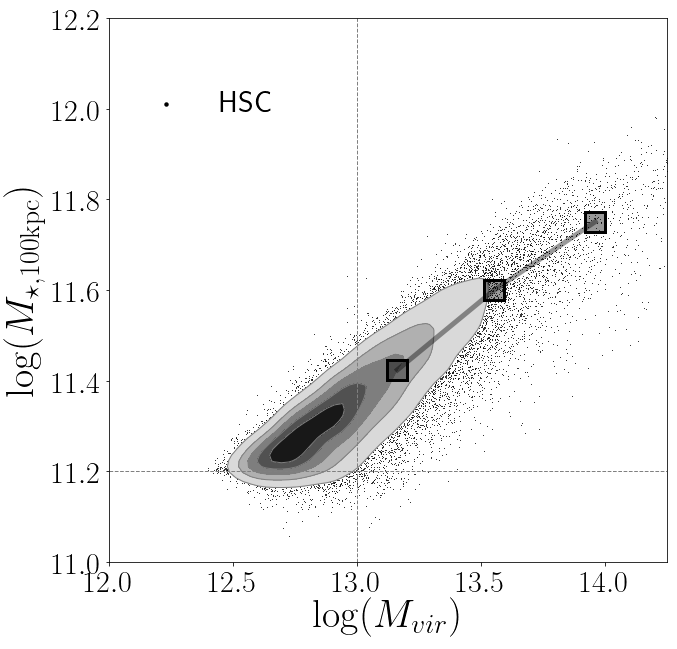

In [78]:
fig = plt.figure(figsize=[10,10])
#empty to move down legend
plt.scatter(tng_m_vir, tng_m100, color='w', label='.', s=0, linewidth=0, zorder=5)


#hsc
plt.scatter(hsc_m_vir_sr, hsc_m100, marker='o', color='k', label='HSC', s=1, linewidth=0, alpha=1, zorder=0)
sns.kdeplot(hsc_m_vir_sr, hsc_m100, cmap="Greys", shade=True, shade_lowest=False, legend=False,  n_levels=7, zorder =1)
sns.kdeplot(hsc_m_vir_sr, hsc_m100, colors='grey', cmap=None, shade_lowest=False,  n_levels=7, linewidths=1)

#plot medians
plt.plot(bins_x_hsc_m100, bins_y_hsc_m100, markersize=20, color=colorConverter.to_rgba('k', alpha=.4),
         linewidth=5, marker='s', zorder=5, markeredgecolor=colorConverter.to_rgba('k', alpha=1), 
         markeredgewidth=3)



#make cut to include M_100>11.5
plt.axvline(13.0, c='grey', linewidth=1, linestyle='--')
plt.axhline(11.2, c='grey', linewidth=1, linestyle='--')

plt.xlabel('$\log (M_{vir})$', fontsize=40)
plt.ylabel('$\log (M_{\star, 100\mathrm{kpc}})$', fontsize=40)

plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlim([12,14.25])
plt.ylim([11,12.2])


#legend
lgnd = plt.legend(fontsize=30, scatterpoints=1, frameon=False, loc='upper left')#, markerscale=2.)#, handler_map={hsc_points: HandlerLine2D(numpoints=3)})
#change the marker size manually for both lines
lgnd.legendHandles[1]._sizes = [20.]
lgnd.get_texts()[0].set_color("w")

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/Mhalo_vs_M100a.pdf',
            dpi=100, format='pdf', bbox_inches='tight')



plt.show()

### hsc+Illustris 

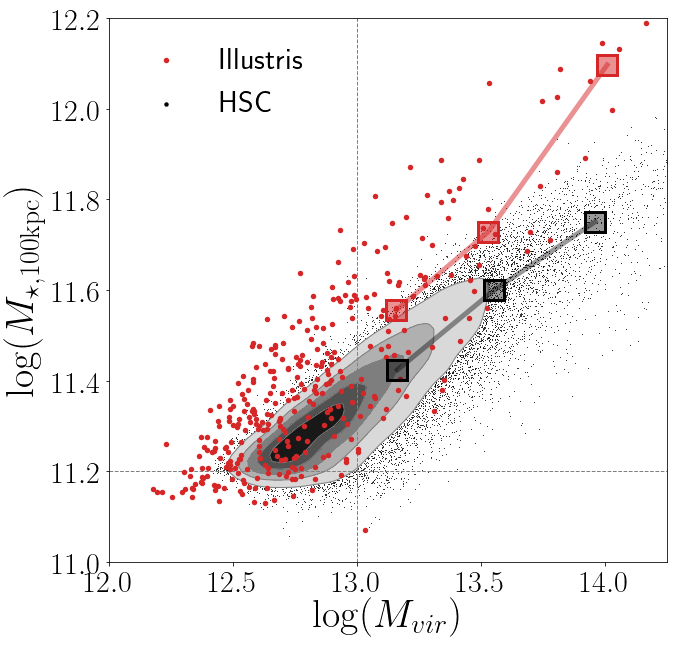

In [79]:
fig = plt.figure(figsize=[10,10])
plt.scatter(illustris_m_vir, illustris_m100, color=u'#d62728', label='Illustris', s=30, linewidth=0, zorder=5)

#hsc
plt.scatter(hsc_m_vir_sr, hsc_m100, marker='o', color='k', label='HSC', s=1, linewidth=0, alpha=1, zorder=0)
sns.kdeplot(hsc_m_vir_sr, hsc_m100, cmap="Greys", shade=True, shade_lowest=False, legend=False,  n_levels=7, zorder =1)
sns.kdeplot(hsc_m_vir_sr, hsc_m100, colors='grey', cmap=None, shade_lowest=False,  n_levels=7, linewidths=1)

#plot medians
plt.plot(bins_x_illustris_m100, bins_y_illustris_m100, markersize=20, color=colorConverter.to_rgba(u'#d62728', alpha=.5),
         linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba(u'#d62728', alpha=1), 
         markeredgewidth=3)
plt.plot(bins_x_hsc_m100, bins_y_hsc_m100, markersize=20, color=colorConverter.to_rgba('k', alpha=.4),
         linewidth=5, marker='s', zorder=5, markeredgecolor=colorConverter.to_rgba('k', alpha=1), 
         markeredgewidth=3)

#make cut to include M_100>11.5
plt.axvline(13.0, c='grey', linewidth=1, linestyle='--')
plt.axhline(11.2, c='grey', linewidth=1, linestyle='--')

plt.xlabel('$\log (M_{vir})$', fontsize=40)
plt.ylabel('$\log (M_{\star, 100\mathrm{kpc}})$', fontsize=40)

plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlim([12,14.25])
plt.ylim([11,12.2])


#legend
lgnd = plt.legend(fontsize=30, scatterpoints=1, frameon=False, loc='upper left')#, markerscale=2.)#, handler_map={hsc_points: HandlerLine2D(numpoints=3)})
#change the marker size manually for both lines
lgnd.legendHandles[1]._sizes = [20.]

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/Mhalo_vs_M100b.pdf',
            dpi=100, format='pdf', bbox_inches='tight')



plt.show()

### hsc+tng

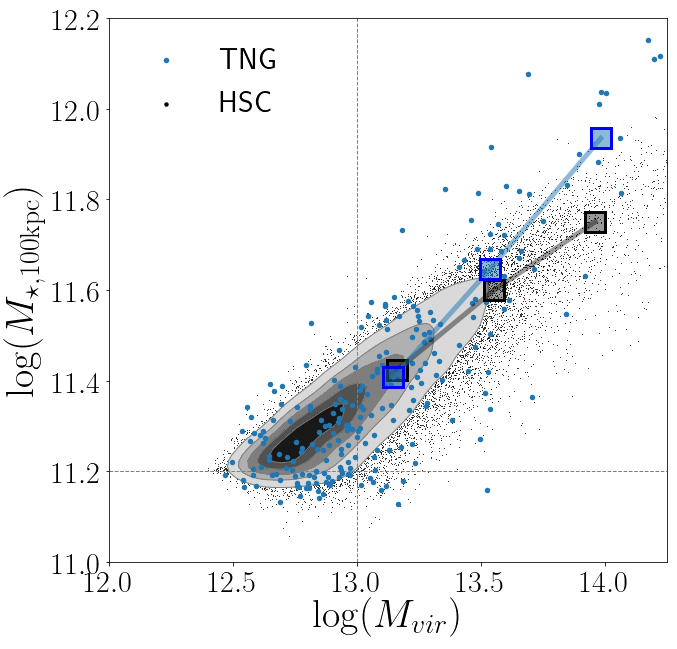

In [80]:
fig = plt.figure(figsize=[10,10])
plt.scatter(tng_m_vir, tng_m100, color=u'#1f77b4', label='TNG', s=30, linewidth=0, zorder=5)

#hsc
plt.scatter(hsc_m_vir_sr, hsc_m100, marker='o', color='k', label='HSC', s=1, linewidth=0, alpha=1, zorder=0)
sns.kdeplot(hsc_m_vir_sr, hsc_m100, cmap="Greys", shade=True, shade_lowest=False, legend=False,  n_levels=7, zorder =1)
sns.kdeplot(hsc_m_vir_sr, hsc_m100, colors='grey', cmap=None, shade_lowest=False,  n_levels=7, linewidths=1)


#plot medians
plt.plot(bins_x_tng_m100, bins_y_tng_m100, markersize=20, color=colorConverter.to_rgba(u'#1f77b4', alpha=.5),
         linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba('b', alpha=1), 
         markeredgewidth=3)
plt.plot(bins_x_hsc_m100, bins_y_hsc_m100, markersize=20, color=colorConverter.to_rgba('k', alpha=.4),
         linewidth=5, marker='s', zorder=5, markeredgecolor=colorConverter.to_rgba('k', alpha=1), 
         markeredgewidth=3)


#make cut to include M_100>11.5
plt.axvline(13.0, c='grey', linewidth=1, linestyle='--')
plt.axhline(11.2, c='grey', linewidth=1, linestyle='--')

plt.xlabel('$\log (M_{vir})$', fontsize=40)
plt.ylabel('$\log (M_{\star, 100\mathrm{kpc}})$', fontsize=40)

plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlim([12,14.25])
plt.ylim([11,12.2])


#legend
lgnd = plt.legend(fontsize=30, scatterpoints=1, frameon=False, loc='upper left')#, markerscale=2.)#, handler_map={hsc_points: HandlerLine2D(numpoints=3)})
#change the marker size manually for both lines
lgnd.legendHandles[1]._sizes = [20.]

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/Mhalo_vs_M100c.pdf',
            dpi=100, format='pdf', bbox_inches='tight')



plt.show()

## plot M30, Mhalo

In [83]:
illustris_m30 = illustris_masses['m_1d_30']
tng_m30 = tng_masses['m_1d_30']

In [84]:
n_bins=3
lower_bin = 13
upper_bin = 14.25
median_bins = np.linspace(lower_bin,upper_bin,n_bins+1)

bins_x_illustris_m30, bins_y_illustris_m30 = get_median(median_bins, illustris_m_vir, illustris_m30)
bins_x_tng_m30, bins_y_tng_m30 = get_median(median_bins, tng_m_vir, tng_m30)
bins_x_hsc_m30, bins_y_hsc_m30 = get_median(median_bins, hsc_m_vir_sr, hsc_m30)

63
21
6
82
35
13
9146
2807
638


/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


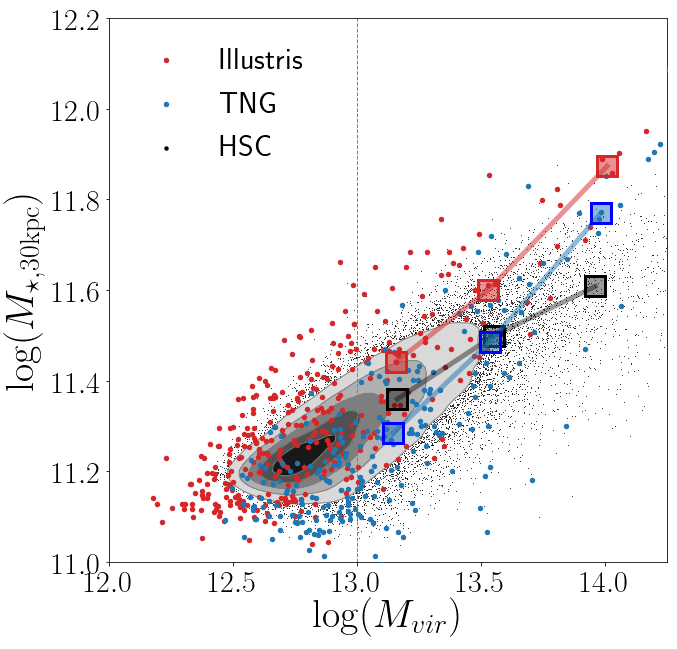

In [85]:
fig = plt.figure(figsize=[10,10])
plt.scatter(illustris_m_vir, illustris_m30, color=u'#d62728', label='Illustris', s=30, linewidth=0, zorder=5)
plt.scatter(tng_m_vir, tng_m30, color=u'#1f77b4', label='TNG', s=30, linewidth=0, zorder=5)

#hsc
plt.scatter(hsc_m_vir_sr, hsc_m30, marker='o', color='k', label='HSC', s=1, linewidth=0, alpha=1, zorder=0)
sns.kdeplot(hsc_m_vir_sr, hsc_m30, cmap="Greys", shade=True, shade_lowest=False, legend=False,  n_levels=7, zorder =1)
sns.kdeplot(hsc_m_vir_sr, hsc_m30, colors='grey', cmap=None, shade_lowest=False,  n_levels=7, linewidths=1)

# #linear fit
# plt.plot(xs, illustris_line(xs), c=u'#d62728', linewidth=3)
# plt.plot(xs, tng_line(xs), c=u'#1f77b4', linewidth=3)
# #plt.plot(xs, hsc_line_rf(xs), c='k', linestyle=':', label='HSC: random forest')
# plt.plot(xs, hsc_line_sr(xs), c='k', alpha=0.75, linestyle='-', linewidth=3)#, label='HSC: sybolic regression')

#plot medians
plt.plot(bins_x_illustris_m30, bins_y_illustris_m30, markersize=20, color=colorConverter.to_rgba(u'#d62728', alpha=.5),
         linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba(u'#d62728', alpha=1), 
         markeredgewidth=3)
plt.plot(bins_x_tng_m30, bins_y_tng_m30, markersize=20, color=colorConverter.to_rgba(u'#1f77b4', alpha=.5),
         linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba('b', alpha=1), 
         markeredgewidth=3)
plt.plot(bins_x_hsc_m30, bins_y_hsc_m30, markersize=20, color=colorConverter.to_rgba('k', alpha=.4),
         linewidth=5, marker='s', zorder=5, markeredgecolor=colorConverter.to_rgba('k', alpha=1), 
         markeredgewidth=3)

#make cut to include M_30>11.5
plt.axvline(13.0, c='grey', linewidth=1, linestyle='--')
# plt.axhline(11.2, c='grey', linewidth=1, linestyle='--')

plt.xlabel('$\log (M_{vir})$', fontsize=40)
plt.ylabel('$\log (M_{\star, 30\mathrm{kpc}})$', fontsize=40)

plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlim([12,14.25])
plt.ylim([11,12.2])


#legend
lgnd = plt.legend(fontsize=30, scatterpoints=1, frameon=False)#, markerscale=2.)#, handler_map={hsc_points: HandlerLine2D(numpoints=3)})
#change the marker size manually for both lines
lgnd.legendHandles[2]._sizes = [20.]

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/Mhalo_vs_M30.pdf',
            dpi=100, format='pdf', bbox_inches='tight')



plt.show()

## plot M10, Mhalo

In [86]:
illustris_m10 = illustris_masses['m_1d_10']
tng_m10 = tng_masses['m_1d_10']


In [87]:
n_bins=3
lower_bin = 13
upper_bin = 14.25
median_bins = np.linspace(lower_bin,upper_bin,n_bins+1)

bins_x_illustris_m10, bins_y_illustris_m10 = get_median(median_bins, illustris_m_vir, illustris_m10)
bins_x_tng_m10, bins_y_tng_m10 = get_median(median_bins, tng_m_vir, tng_m10)
bins_x_hsc_m10, bins_y_hsc_m10 = get_median(median_bins, hsc_m_vir_sr, hsc_m10)

63
21
6
82
35
13
9146
2807
638


/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


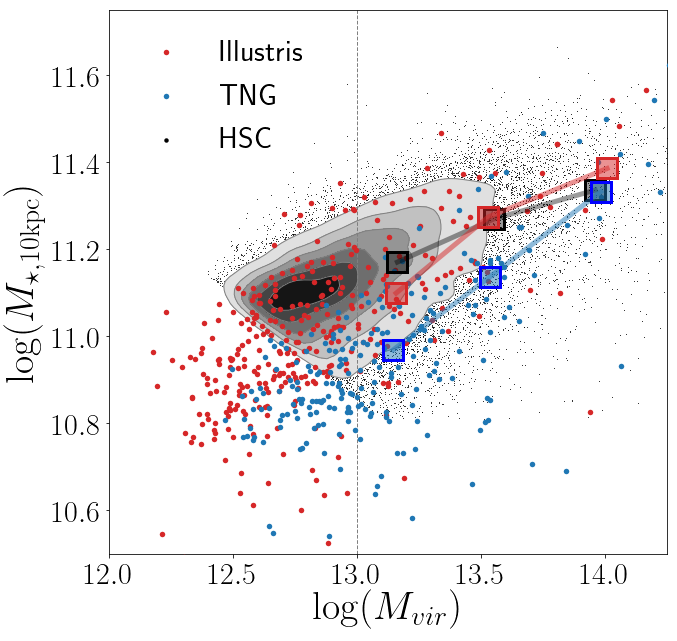

In [88]:
fig = plt.figure(figsize=[10,10])
plt.scatter(illustris_m_vir, illustris_m10, color=u'#d62728', label='Illustris', s=30, linewidth=0, zorder=5)
plt.scatter(tng_m_vir, tng_m10, color=u'#1f77b4', label='TNG', s=30, linewidth=0, zorder=5)

#hsc
plt.scatter(hsc_m_vir_sr, hsc_m10, marker='o', color='k', label='HSC', s=1, linewidth=0, alpha=1, zorder=0)
sns.kdeplot(hsc_m_vir_sr, hsc_m10, cmap="Greys", shade=True, shade_lowest=False, legend=False,  n_levels=7, zorder =1)
sns.kdeplot(hsc_m_vir_sr, hsc_m10, colors='grey', cmap=None, shade_lowest=False,  n_levels=7, linewidths=1)

# #linear fit
# plt.plot(xs, illustris_line(xs), c=u'#d62728', linewidth=3)
# plt.plot(xs, tng_line(xs), c=u'#1f77b4', linewidth=3)
# #plt.plot(xs, hsc_line_rf(xs), c='k', linestyle=':', label='HSC: random forest')
# plt.plot(xs, hsc_line_sr(xs), c='k', alpha=0.75, linestyle='-', linewidth=3)#, label='HSC: sybolic regression')

#plot medians
plt.plot(bins_x_illustris_m10, bins_y_illustris_m10, markersize=20, color=colorConverter.to_rgba(u'#d62728', alpha=.5),
         linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba(u'#d62728', alpha=1), 
         markeredgewidth=3)
plt.plot(bins_x_tng_m10, bins_y_tng_m10, markersize=20, color=colorConverter.to_rgba(u'#1f77b4', alpha=.5),
         linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba('b', alpha=1), 
         markeredgewidth=3)
plt.plot(bins_x_hsc_m10, bins_y_hsc_m10, markersize=20, color=colorConverter.to_rgba('k', alpha=.4),
         linewidth=5, marker='s', zorder=5, markeredgecolor=colorConverter.to_rgba('k', alpha=1), 
         markeredgewidth=3)

#make cut to include M_10>11.5
plt.axvline(13.0, c='grey', linewidth=1, linestyle='--')
# plt.axhline(11.2, c='grey', linewidth=1, linestyle='--')

plt.xlabel('$\log (M_{vir})$', fontsize=40)
plt.ylabel('$\log (M_{\star, 10\mathrm{kpc}})$', fontsize=40)

plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlim([12,14.25])
plt.ylim([10.5,11.75])


#legend
lgnd = plt.legend(fontsize=30, scatterpoints=1, frameon=False)#, markerscale=2.)#, handler_map={hsc_points: HandlerLine2D(numpoints=3)})
#change the marker size manually for both lines
lgnd.legendHandles[2]._sizes = [20.]

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/Mhalo_vs_M10.pdf',
            dpi=100, format='pdf', bbox_inches='tight')



plt.show()

# compare both hsc massses

In [28]:
hsc_lin_params1 = np.polyfit(hsc_m_dm_sr, hsc_m100,1)
hsc_line1 = np.poly1d(hsc_lin_params1)

hsc_lin_params2 = np.polyfit(hsc_m_dm_rf, hsc_m100,1)
hsc_line2 = np.poly1d(hsc_lin_params2)

In [39]:
xs = np.linspace(12,15,100)

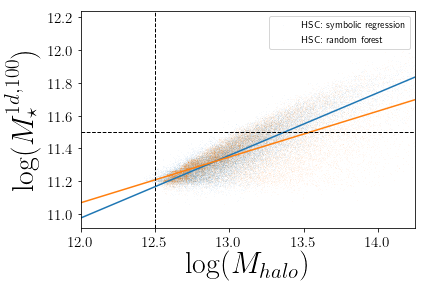

In [40]:
plt.scatter(hsc_m_dm_sr, hsc_m100, label='HSC: symbolic regression', s=1, linewidth=0, alpha=0.05, zorder=1)
plt.scatter(hsc_m_dm_rf, hsc_m100, label='HSC: random forest', s=1, linewidth=0, alpha=0.05, zorder=1)

#linear fit
plt.plot(xs, hsc_line1(xs))
plt.plot(xs, hsc_line2(xs))

#make cut to include M_100>11.5
plt.axhline(11.5, c='k', linewidth=1, linestyle='--')
plt.axvline(12.5, c='k', linewidth=1, linestyle='--')

plt.xlabel('$\log (M_{halo})$', fontsize=30)
plt.ylabel('$\log (M_{\star}^{1d, 100})$', fontsize=30)

plt.tick_params(axis='both', which='major', labelsize=15)

plt.xlim([12,14.25])

plt.legend(fontsize=10)
plt.show()

### M_halo > 13 

In [30]:
illustris_m_dm_cut = illustris_m_dm[illustris_m_dm>13]
tng_m_dm_cut = tng_m_dm[tng_m_dm>13]

In [31]:
#function to count number of galaxies in each mass bin
def num_gals(masses, mass_bins):
    n_bins = len(mass_bins) - 1
    
    gals_per_bin=[]
    
    for bin in range(n_bins):
        lower = mass_bins[bin]
        upper = mass_bins[bin+1]
        
        gals = masses[(masses>lower) & (masses<upper)]
        
        gals_per_bin.append(len(gals))
        
    return gals_per_bin

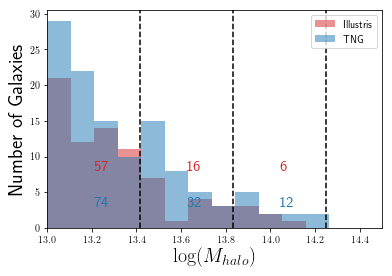

In [32]:
plt.hist(illustris_m_dm_cut, bins=np.linspace(13,15,20), alpha=0.5, color=u'#d62728', label='Illustris')
plt.hist(tng_m_dm_cut, bins=np.linspace(13,15,20), alpha=0.5, color=u'#1f77b4', label='TNG')

plt.xlim([13,14.5])

#number in each mass bin
tng_n_per_bin = num_gals(tng_m_dm , mass_bins )
illustris_n_per_bin = num_gals(illustris_m_dm , mass_bins )
for i in range(len(tng_n_per_bin)):
    plt.text(np.mean(mass_bins[i:i+2]), 8, str(illustris_n_per_bin[i]), fontsize=15, color=u'#d62728')
    plt.text(np.mean(mass_bins[i:i+2]), 3, str(tng_n_per_bin[i]), fontsize=15, color=u'#1f77b4')
    
    plt.axvline(mass_bins[i+1], linestyle='--', color='k')
    

plt.legend(loc='upper right')

plt.xlabel('$\log (M_{halo})$', fontsize=20)
plt.ylabel('Number of Galaxies', fontsize=20)
plt.show()

# Surface brightness profiles

## get HSC profiles in each mass bin 

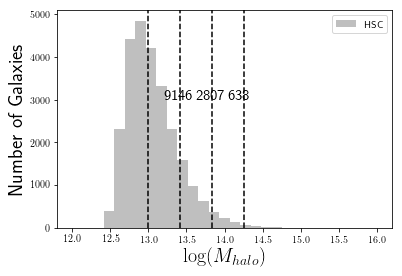

In [33]:
plt.hist(hsc_table['logmh_vir_symbol'], bins=np.linspace(12,16,30), alpha=0.5, color='grey', label='HSC')

#plt.xlim([13,14.5])

#number in each mass bin
hsc_n_per_bin = num_gals(hsc_table['logmh_vir_symbol'] , mass_bins)

plt.axvline(mass_bins[0], linestyle='--', color='k')

for i in range(len(tng_n_per_bin)):
    plt.text(np.mean(mass_bins[i:i+2]), 3000, str(hsc_n_per_bin[i]), fontsize=15, color='k')
    
    plt.axvline(mass_bins[i+1], linestyle='--', color='k')
    

plt.legend(loc='upper right')

plt.xlabel('$\log (M_{halo})$', fontsize=20)
plt.ylabel('Number of Galaxies', fontsize=20)
plt.show()

In [34]:
def hsc_profiles_in_bin(hsc_gals, mass_bins):
    n_bins = len(mass_bins) - 1
    
    profiles_in_bins=[]
    
    for bin in range(n_bins):
        lower = mass_bins[bin]
        upper = mass_bins[bin+1]
        
        sbps = hsc_gals['sbp'][(hsc_gals['logmh_vir_symbol']>lower) & (hsc_gals['logmh_vir_symbol']<upper)]
        
        profiles_in_bins.append(sbps)
        
    return profiles_in_bins

In [35]:
hsc_profiles = hsc_profiles_in_bin(hsc_table, mass_bins)
hsc_sma = np.arange(0.4, 4.2, 0.01)